## Table of Contents
* [Load data and clean](#chapter1)

* [Create functions](#chapter2)

* [Get Dataframes](#chapter3)

* [Plots](#chapter4)

* [Remarks](#chapter5)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# set seaborn plot style
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.8)

## Load data and clean <a class="anchor" id="chapter1"></a>

In [2]:
# load dataframes from csv files
shots = pd.read_csv('/Users/Cory/Documents/NBA/Player & Team Stats/shots_2015-23.csv', parse_dates=['Date'])
team_season_records = pd.read_csv('/Users/Cory/Documents/NBA/Player & Team Stats/season_wins_2015-23.csv')

In [3]:
shots.head()

,URL,Date,GameType,SeasonYear,Team,Shooter,ShotType,ShotOutcome,PointsMadeShot,ShotDist (ft)
0,/boxscores/201510270ATL.html,2015-10-27 20:00:00,regular,2015-16,DET,drumman01,2-pt layup,miss,NaN,1.0
1,/boxscores/201510270ATL.html,2015-10-27 20:00:00,regular,2015-16,DET,morrima03,2-pt jump shot,make,2.0,13.0
2,/boxscores/201510270ATL.html,2015-10-27 20:00:00,regular,2015-16,ATL,millspa01,2-pt jump shot,make,2.0,12.0
3,/boxscores/201510270ATL.html,2015-10-27 20:00:00,regular,2015-16,DET,caldwke01,2-pt jump shot,make,2.0,8.0
4,/boxscores/201510270ATL.html,2015-10-27 20:00:00,regular,2015-16,ATL,horfoal01,2-pt jump shot,miss,NaN,20.0


In [4]:
team_season_records.head()

,SeasonYear,Team,Wins
0,2015-16,DET,44
1,2016-17,DET,37
2,2017-18,DET,39
3,2018-19,DET,41
4,2019-20,DET,20


In [5]:
# view all shot types and their quantities
shots['ShotType'].value_counts()

3-pt jump shot    637529
2-pt jump shot    513593
2-pt layup        472343
foul shot         463895
2-pt dunk          97318
2-pt hook shot     58229
3-pt layup            13
2-pt tip-in           13
3-pt hook shot        10
Name: ShotType, dtype: int64

In [6]:
# since 3-pt layup, 2-pt tip-in, & 3-pt hook shots are rare, remove them to avoid clutter in charts
remove_types = ['3-pt layup', '2-pt tip-in', '3-pt hook shot']
shots = shots.loc[(~shots['ShotType'].isin(remove_types))]

In [7]:
# create a variable for the max distance of a two point shot (in feet), It was discovered through exploration of the data
# some 2 & 3 point jumpt shot distances were incorrectly recorded
max_dist_two_point = 24 # Max three point distance is 23.75 ft., but shot distances are rounded
min_dist_three_point = 22

# get indices where two point shots were recorded greater than 24 ft
two_pt_shot_ind = shots.loc[(shots['ShotType'] == '2-pt jump shot') & (shots['ShotDist (ft)'] > max_dist_two_point)].index.to_list()

# TODO: some three point jump shots also have incorrect distances associated with them
three_pt_shot_ind = shots.loc[(shots['ShotType'] == '3-pt jump shot') & (shots['ShotDist (ft)'] < min_dist_three_point)].index.to_list()

# drop these indeces from the dataframe
shots.drop(two_pt_shot_ind + three_pt_shot_ind, inplace=True)

## Functions <a class="anchor" id="chapter2"></a>
This section of the notebook is dedicated to defining functions that are used to gather data from the shots dataframe 

In [8]:
def filter_shots_on_game_type(shots, game_type):
    '''
    Filter the shots dataframe based on the desired game type(s).

    Parameters
    ----------
    shots : DataFrame
        The original shots DataFrame.

    game_type : str
        The game type to filter on. Valid options are:
        - "Regular Season Games"
        - "Playoff Games"
        - "Regular & Playoff Games" (to include all games)

    Returns
    -------
    DataFrame
        A filtered shots DataFrame based on the game type.

    Raises
    ------
    ValueError
        If an invalid option is chosen for the game type. Valid options are: 
        "Regular Season Games", "Playoff Games", or "Regular & Playoff Games".
    '''
    if game_type == 'Regular Season Games':
        shots_filtered = shots.loc[(shots['GameType']) == 'regular']
        return shots_filtered
    
    elif game_type == 'Playoff Games':
        shots_filtered = shots.loc[(shots['GameType']) == 'playoff']
        return shots_filtered
    
    elif game_type == 'Regular & Playoff Games':
        return shots
    
    else:
        raise(ValueError('invalid option chosen for game type (choose "Regular Season Games", "Playoff Games", or "All Games")'))

In [9]:
def get_total_makes_misses_accuracy(row):
    '''
    Get the total makes, misses, and accuracy for a given row of game data.

    Parameters
    ----------
    row : pd.Series
        A row from the game data DataFrame.

    Returns
    -------
    pd.Series
        A Series containing the total makes, misses, and accuracy for the given row.
    '''
    if '2-pt' in row['ShotType']:
        shots_made = row['TotalPointsMade'] / 2
        shots_missed = row['TotalShotAttempts'] - shots_made
        accuracy = shots_made / row['TotalShotAttempts']
        return pd.Series([shots_made, shots_missed, round(accuracy,3)])
    
    elif '3-pt' in row['ShotType']:
        shots_made = row['TotalPointsMade'] / 3
        shots_missed = row['TotalShotAttempts'] - shots_made
        accuracy = shots_made / row['TotalShotAttempts']
        return pd.Series([shots_made, shots_missed, round(accuracy,3)])
    
    elif 'foul' in row['ShotType']:
        shots_made = row['TotalPointsMade']
        shots_missed = row['TotalShotAttempts'] - shots_made
        accuracy = shots_made / row['TotalShotAttempts']
        return pd.Series([shots_made, shots_missed, round(accuracy,3)])

In [10]:
def get_num_games_season_df(shots_filtered_by_game_type):
    '''
    Create a dataframe with the number of games played for each season.
    
    Note: play-in tournament games counts as regular season games

    Parameters
    ----------
    shots_filtered_by_game_type : DataFrame
        The shots DataFrame filtered by game type.

    Returns
    -------
    DataFrame
        A DataFrame containing the number of games played for each season.
    '''
    num_games_regular_season_df = shots_filtered_by_game_type[['URL', 'SeasonYear']]\
                                         .drop_duplicates()['SeasonYear'].value_counts(sort=False).rename('NumGames')\
                                         .reset_index().rename(columns={"index": 'SeasonYear'})
    return num_games_regular_season_df

In [11]:
def get_num_games_season_per_team_df(shots_filtered_by_game_type):
    '''
    Create a dataframe with the number of games played for each team for each season.
    
    Note: play-in tournament games counts as regular season games

    Parameters
    ----------
    shots_filtered_by_game_type : DataFrame
        The shots DataFrame filtered by game type.

    Returns
    -------
    DataFrame
        A DataFrame containing the number of games played for each team for each season.
    '''
    # get a dataframe including unique season and teams
    teams_year_df = shots_filtered_by_game_type[['URL', 'SeasonYear', 'Team']].drop_duplicates()
    # group by season and count the number of teams
    games_played_season = teams_year_df.groupby(['SeasonYear', 'Team']).count().reset_index()
    # rename URL column
    games_played_season.rename(columns={"URL": 'NumGames'}, inplace=True)

    return games_played_season

In [12]:
def get_shot_stats_per_game(shots_filtered_by_game_type):
    '''
    Create a dataframe that shows the sum of total attempts,
    points, shots made, shots missed, and accuracy for each shot type, for each game.

    Parameters
    ----------
    shots_filtered_by_game_type : DataFrame
        The shots DataFrame filtered by game type.

    Returns
    -------
    DataFrame
        A DataFrame containing shot statistics for each shot type, for each game.
    '''
    # get a count of each shot type attempted for each game
    game_shottype_count = shots_filtered_by_game_type.groupby(['URL', 'ShotType']).count()['Shooter']
    game_shottype_count = game_shottype_count.reset_index()
    game_shottype_count.rename(columns={"Shooter": 'TotalShotAttempts'}, inplace=True)
    
    # get total points scored for each shot type
    game_shottype_points_sum = shots_filtered_by_game_type.groupby(['URL', 'ShotType']).sum(numeric_only=True)['PointsMadeShot']
    game_shottype_points_sum = game_shottype_points_sum.reset_index()
    game_shottype_points_sum.rename(columns={"PointsMadeShot": 'TotalPointsMade'}, inplace=True)

    # merge dataframes
    game_shot_attempts_and_points = game_shottype_count.merge(game_shottype_points_sum, on=['URL', 'ShotType'])
    
    # add columns for shots made/missed and accuracy
    game_shot_attempts_and_points[['GameShotsMade', 'GameShotsMissed', 'GameAccuracy']] = game_shot_attempts_and_points.apply(get_total_makes_misses_accuracy, axis=1)
    
    return game_shot_attempts_and_points

In [13]:
def get_shot_stats_per_season(shots_filtered_by_game_type, num_games_season_df):
    '''
    Create a dataframe that shows the sum of total attempts,
    points, shots made, shots missed, and accuracy for each season.
    Also includes points per game and shot attempts per game.

    Parameters
    ----------
    shots_filtered_by_game_type : DataFrame
        The shots DataFrame filtered by game type.

    num_games_season_df : DataFrame
        The number of games played for each season DataFrame.

    Returns
    -------
    DataFrame
        A DataFrame containing shot statistics for each season, including points per game and shot attempts per game.
    '''
    # get a count of each shot type attempted for entire season
    season_shottype_count = shots_filtered_by_game_type.groupby(['SeasonYear', 'ShotType']).count()['Shooter']
    season_shottype_count = season_shottype_count.reset_index()
    season_shottype_count.rename(columns={"Shooter": 'TotalShotAttempts'}, inplace=True)
    
    # get total points scored for each shot type
    season_shottype_points_sum = shots_filtered_by_game_type.groupby(['SeasonYear', 'ShotType']).sum(numeric_only=True)['PointsMadeShot']
    season_shottype_points_sum = season_shottype_points_sum.reset_index()
    season_shottype_points_sum.rename(columns={"PointsMadeShot": 'TotalPointsMade'}, inplace=True)
                                           
    # merge dataframes
    season_shot_attempts_and_points = season_shottype_count.merge(season_shottype_points_sum, on=['SeasonYear', 'ShotType'])
    
    season_shot_attempts_and_points = season_shot_attempts_and_points.merge(num_games_season_df, on=['SeasonYear'])
    
    # move 'NumGames' column
    season_shot_attempts_and_points.insert(1, 'NumGames', season_shot_attempts_and_points.pop('NumGames'))
    
    # add columns for shots made/missed and accuracy
    season_shot_attempts_and_points[['SeasonShotsMade', 'SeasonShotsMissed', 'SeasonAccuracy']] = season_shot_attempts_and_points.apply(get_total_makes_misses_accuracy, axis=1)
    
    # add column for shots/game and points/game
    season_shot_attempts_and_points['ShotAttemptsPerGame'] = round(season_shot_attempts_and_points['TotalShotAttempts'] / season_shot_attempts_and_points['NumGames'], 2)
    season_shot_attempts_and_points['PointsPerGame'] = round(season_shot_attempts_and_points['TotalPointsMade'] / season_shot_attempts_and_points['NumGames'], 2)
    
    return season_shot_attempts_and_points

In [14]:
def get_team_shot_stats_by_season(shots_filtered, num_games_team_season_df):
    '''
    Create a dataframe that displays the sum of total attempts, points, shots made,
    shots missed, and accuracy for each season, for each team.

    Parameters
    ----------
    shots_filtered_by_game_type : DataFrame
        The shots DataFrame filtered by game type.

    num_games_team_season_df : DataFrame
        The number of games played for each team for each season DataFrame.

    Returns
    -------
    DataFrame
        A DataFrame containing shot statistics for each season, for each team.
    '''
    # get a count of each shot type attempted for entire season
    season_shottype_count = shots_filtered_by_game_type.groupby(['SeasonYear','Team', 'ShotType']).count()['Shooter']
    season_shottype_count = season_shottype_count.reset_index()
    season_shottype_count.rename(columns={"Shooter": 'TotalShotAttempts'}, inplace=True)

    # get total points scored for each shot type
    season_shottype_points_sum = shots_filtered_by_game_type.groupby(['SeasonYear', 'Team', 'ShotType']).sum(numeric_only=True)['PointsMadeShot']
    season_shottype_points_sum = season_shottype_points_sum.reset_index()
    season_shottype_points_sum.rename(columns={"PointsMadeShot": 'TotalPointsMade'}, inplace=True)
    
    # merge dataframes
    season_shot_attempts_and_points_by_team = season_shottype_count.merge(season_shottype_points_sum, on=['SeasonYear', 'Team', 'ShotType'])
    
    season_shot_attempts_and_points_by_team = season_shot_attempts_and_points_by_team.merge(num_games_team_season_df, on=['SeasonYear', 'Team'])
    
    # move 'NumGames' column
    season_shot_attempts_and_points_by_team.insert(1, 'NumGames', season_shot_attempts_and_points_by_team.pop('NumGames'))
    
    # add columns for shots made/missed and accuracy
    season_shot_attempts_and_points_by_team[['SeasonShotsMade', 'SeasonShotsMissed', 'SeasonAccuracy']] = season_shot_attempts_and_points_by_team.apply(get_total_makes_misses_accuracy, axis=1)
    
    # add column for shots/game and points/game
    season_shot_attempts_and_points_by_team['ShotAttemptsPerGame'] = round(season_shot_attempts_and_points_by_team['TotalShotAttempts'] / season_shot_attempts_and_points_by_team['NumGames'], 2)
    season_shot_attempts_and_points_by_team['PointsPerGame'] = round(season_shot_attempts_and_points_by_team['TotalPointsMade'] / season_shot_attempts_and_points_by_team['NumGames'], 2)
    
    return season_shot_attempts_and_points_by_team

In [15]:
def get_points_per_game_by_season(season_shots_df, num_games_season_df):
    '''
    Create a dataframe that reports the average points per game
    for each season.

    Parameters
    ----------
    season_shots_df : DataFrame
        The DataFrame generated by the get_shot_stats_per_season function.

    num_games_season_df : DataFrame
        The number of games played for each season DataFrame.

    Returns
    -------
    DataFrame
        A DataFrame containing the average points per game for each season.
    '''
    # group season_shots_df by season year and sum points scored
    points_per_game = season_shots_df.groupby(['SeasonYear']).sum(numeric_only=True)['TotalPointsMade'].reset_index()
    
    # merge dataframes
    points_per_game_season = points_per_game.merge(num_games_season_df, on=['SeasonYear'])
    
    # add column for points/game
    points_per_game_season['PointsPerGame'] = round(points_per_game_season['TotalPointsMade'] / points_per_game_season['NumGames'], 1)

    return points_per_game_season

In [16]:
def get_top_x_scorers(shots_filtered_by_game_type, years, x):
    '''
    Return a list of the top x scorers over the specified years.

    Parameters
    ----------
    shots_filtered_by_game_type : DataFrame
        The shots DataFrame filtered by game type.

    years : str or list
        The years to consider for finding top scorers. Use 'all' for all available years
        or specify a list of specific years.

    x : int
        The number of top scorers to return.

    Returns
    -------
    list
        A list of the top x scorers over the selected years.
    '''
    
    if years == 'all':
        # get a grouped by shooter dataframe for all available years, sum the players points made, and return top 25 scorers
        player_shot_total = shots_filtered_by_game_type.groupby(['Shooter']).sum(numeric_only=True)['PointsMadeShot'].sort_values(ascending=False).iloc[0:x]
        players = player_shot_total.index.to_list()
        return players
    else:
        # get a dataframe containing only these years
        shots_years_df = shots_filtered_by_game_type.loc[(shots_filtered_by_game_type['SeasonYear'].isin(years))]
        # get a grouped by shooter dataframe for the years specified, sum the players points made, and return top 25 scorers
        player_shot_total = shots_years_df.groupby(['Shooter']).sum(numeric_only=True)['PointsMadeShot'].sort_values(ascending=False).iloc[0:x]
        players = player_shot_total.index.to_list()
        return players

In [17]:
def get_expected_points_df(shots_filtered_by_game_type, two_point_shot_interval, three_point_shot_interval, top_x_players='all', previous_years='all'):
    '''
    Calculate the league average probability and expected points scored for different shot distances (intervals)
    for two-point and three-point jump shots based on historical shot data.

    Parameters:
        shots_filtered_by_game_type (DataFrame) : The shots DataFrame filtered by game type.
        
        two_point_shot_interval (int): The desired interval (in feet) for two-point jump shots.
        
        three_point_shot_interval (int): The desired interval (in feet) for three-point jump shots.
        
        top_x_players (str or int, optional): Filter data for the top 'x' players. Use 'all' for all players. Default is 'all'.
        
        previous_years (str or int, optional): Number of previous years to consider. Use 'all' for all available years. Default is 'all'.

    Returns:
        DataFrame: A DataFrame containing the probability of making the shot and the corresponding expected points
        for each interval. The DataFrame includes columns for 'ShotInterval (ft)', 'Probability', 'ExpectedPoints', and 'ShotType'.
        
        'ShotInterval (ft)' represents the distance interval for the shots, 'Probability' gives the likelihood of making the shot
        within that interval, 'ExpectedPoints' provides the expected points scored for that interval, and 'ShotType' specifies
        whether the shots are two-point or three-point jump shots.
    '''
    
    # get league accuracy for each interval for two and three point jump shots over all seasons
    two_point_prob_dict = {}
    three_point_prob_dict = {}
    
    # determine the expected points scored for a jump shot as a function of distance
    two_point_shots_bins = np.arange(0, 26, two_point_shot_interval)
    three_point_shots_bins = np.arange(22, 36, three_point_shot_interval)
    
    if previous_years == 'all' and top_x_players == 'all':
        two_point_jump_shots = shots_filtered_by_game_type.loc[shots_filtered_by_game_type['ShotType'] == '2-pt jump shot']
        three_point_jump_shots = shots_filtered_by_game_type.loc[shots_filtered_by_game_type['ShotType'] == '3-pt jump shot']
        
    elif top_x_players != 'all' and previous_years == 'all':
        players = get_top_x_scorers(shots_filtered_by_game_type, previous_years, top_x_players)
        two_point_jump_shots = shots_filtered_by_game_type.loc[(shots_filtered_by_game_type['ShotType'] == '2-pt jump shot') & (shots_filtered_by_game_type['Shooter'].isin(players))]
        three_point_jump_shots = shots_filtered_by_game_type.loc[(shots_filtered_by_game_type['ShotType'] == '3-pt jump shot') & (shots_filtered_by_game_type['Shooter'].isin(players))]
        
    elif previous_years != 'all':
        # get a list of all previous years
        all_years = shots_filtered_by_game_type['SeasonYear'].unique().tolist()
        all_years.sort()
        last_index = len(all_years) 
        years = all_years[(last_index - previous_years) : last_index]
        two_point_jump_shots = shots_filtered_by_game_type.loc[(shots_filtered_by_game_type['ShotType'] == '2-pt jump shot') & (shots_filtered_by_game_type['SeasonYear'].isin(years))]
        three_point_jump_shots = shots_filtered_by_game_type.loc[(shots_filtered_by_game_type['ShotType'] == '3-pt jump shot') & (shots_filtered_by_game_type['SeasonYear'].isin(years))]
        if top_x_players != 'all':
            players = get_top_x_scorers(shots_filtered_by_game_type, years, top_x_players)
            two_point_jump_shots = two_point_jump_shots.loc[(two_point_jump_shots['Shooter'].isin(players))]
            three_point_jump_shots = three_point_jump_shots.loc[(three_point_jump_shots['Shooter'].isin(players))]
            
    previous_end_feet = None
    # for each value in two_point_shots_bins, create the desired interval
    for shot_dist in two_point_shots_bins:
        # create variables for the interval of feet to capture
        start_feet = shot_dist
        end_feet = shot_dist + two_point_shot_interval
        interval = str(start_feet) + '-' + str(end_feet-1)
        if start_feet < 24 and end_feet > 24:
            end_feet = 24
        if start_feet == 24 and previous_end_feet == 24:
            break
        df_shot_interval = two_point_jump_shots.loc[(two_point_jump_shots['ShotDist (ft)'] >= start_feet) & 
                                                    (two_point_jump_shots['ShotDist (ft)'] < end_feet)]
        # get counts of makes and misses
        counts = df_shot_interval['ShotOutcome'].value_counts()
        makes = counts['make']
        misses = counts['miss']
        # get league probability of making shot within interval
        probability = makes / (makes + misses)
        two_point_prob_dict[interval] = round(probability, 3)
        previous_end_feet = end_feet
    
    # for each value in three_point_shots_bins, create the desired interval
    for shot_dist in three_point_shots_bins:
        # create variables for the interval of feet to capture
        start_feet = shot_dist
        end_feet = shot_dist + three_point_shot_interval
        interval = str(start_feet) + '-' + str(end_feet-1)
        df_shot_interval = three_point_jump_shots.loc[(three_point_jump_shots['ShotDist (ft)'] >= start_feet) & 
                                                      (three_point_jump_shots['ShotDist (ft)'] < end_feet)]
        # get counts of makes and misses
        counts = df_shot_interval['ShotOutcome'].value_counts()
        makes = counts['make']
        misses = counts['miss']
        # get league probability of making shot within interval
        probability = makes / (makes + misses)
        three_point_prob_dict[interval] = round(probability, 3)
        

    # convert dictionaries to dataframes
    Two_point_prob_df = pd.DataFrame.from_dict(two_point_prob_dict, orient='index', columns=['Probability'])
    Two_point_prob_df.reset_index(names='ShotInterval (ft)', inplace=True)
    Three_point_prob_df = pd.DataFrame.from_dict(three_point_prob_dict, orient='index', columns=['Probability'])
    Three_point_prob_df.reset_index(names='ShotInterval (ft)', inplace=True)
    
    # add column for expected points scored
    Two_point_prob_df['ExpectedPoints'] = Two_point_prob_df['Probability'] * 2
    Three_point_prob_df['ExpectedPoints'] = Three_point_prob_df['Probability'] * 3
    
    # add columns to indicate shot type
    Two_point_prob_df['ShotType'] = '2-pt jump shot'
    Three_point_prob_df['ShotType'] = '3-pt jump shot'
    
    # combine dataframes
    two_and_three_point_prob_df = pd.concat([Two_point_prob_df, Three_point_prob_df])
    
    # move ShotType column to front
    two_and_three_point_prob_df.insert(0, 'ShotType', two_and_three_point_prob_df.pop('ShotType'))
    
    return two_and_three_point_prob_df

## Get Dataframes <a class="anchor" id="chapter3"></a>

In [18]:
# create variable to filter data by game type game type options are 'Regular Season Games', 
# 'Playoff Games', 'Regular & Playoff Games'

# select the game type to filter data by
game_type_option = 'Regular & Playoff Games'

# filter the shots dataframe 
shots_filtered_by_game_type = filter_shots_on_game_type(shots, game_type_option)

In [19]:
# get dataframes of the total number of games per season and games played each season by each team
num_games_season_df = get_num_games_season_df(shots_filtered_by_game_type)
num_games_team_season_df = get_num_games_season_per_team_df(shots_filtered_by_game_type)

num_games_season_df

,SeasonYear,NumGames
0,2015-16,1316
1,2016-17,1309
2,2017-18,1312
3,2018-19,1311
4,2019-20,1143
5,2020-21,1171
6,2021-22,1323
7,2022-23,1320


In [20]:
num_games_team_season_df.head()

,SeasonYear,Team,NumGames
0,2015-16,ATL,92
1,2015-16,BOS,88
2,2015-16,BRK,82
3,2015-16,CHI,82
4,2015-16,CHO,89


In [21]:
# get dataframes for shots grouped by type for each game and season
game_shots_df = get_shot_stats_per_game(shots_filtered_by_game_type)
season_shots_df = get_shot_stats_per_season(shots_filtered_by_game_type, num_games_season_df)

game_shots_df.head()

,URL,ShotType,TotalShotAttempts,TotalPointsMade,GameShotsMade,GameShotsMissed,GameAccuracy
0,/boxscores/201510270ATL.html,2-pt dunk,7,14.0,7.0,0.0,1.000
1,/boxscores/201510270ATL.html,2-pt hook shot,6,2.0,1.0,5.0,0.167
2,/boxscores/201510270ATL.html,2-pt jump shot,53,38.0,19.0,34.0,0.358
3,/boxscores/201510270ATL.html,2-pt layup,56,54.0,27.0,29.0,0.482
4,/boxscores/201510270ATL.html,3-pt jump shot,56,60.0,20.0,36.0,0.357


In [22]:
season_shots_df.head()

,SeasonYear,NumGames,ShotType,TotalShotAttempts,TotalPointsMade,SeasonShotsMade,SeasonShotsMissed,SeasonAccuracy,ShotAttemptsPerGame,PointsPerGame
0,2015-16,1316,2-pt dunk,10720,19472.0,9736.0,984.0,0.908,8.15,14.80
1,2015-16,1316,2-pt hook shot,7772,7860.0,3930.0,3842.0,0.506,5.91,5.97
2,2015-16,1316,2-pt jump shot,84515,65674.0,32837.0,51678.0,0.389,64.22,49.90
3,2015-16,1316,2-pt layup,55646,62642.0,31321.0,24325.0,0.563,42.28,47.60
4,2015-16,1316,3-pt jump shot,63628,67566.0,22522.0,41106.0,0.354,48.35,51.34


In [23]:
# get a dataframe for team stats by shot for each season
team_shots_stats_by_season = get_team_shot_stats_by_season(shots, num_games_team_season_df)

team_shots_stats_by_season.head()

,SeasonYear,NumGames,Team,ShotType,TotalShotAttempts,TotalPointsMade,SeasonShotsMade,SeasonShotsMissed,SeasonAccuracy,ShotAttemptsPerGame,PointsPerGame
0,2015-16,92,ATL,2-pt dunk,282,496.0,248.0,34.0,0.879,3.07,5.39
1,2015-16,92,ATL,2-pt hook shot,177,170.0,85.0,92.0,0.480,1.92,1.85
2,2015-16,92,ATL,2-pt jump shot,2379,1910.0,955.0,1424.0,0.401,25.86,20.76
3,2015-16,92,ATL,2-pt layup,2287,2650.0,1325.0,962.0,0.579,24.86,28.80
4,2015-16,92,ATL,3-pt jump shot,2646,2763.0,921.0,1725.0,0.348,28.76,30.03


In [24]:
# merge team_shots_stats_by_season and team_season_records
team_shots_stats_and_record_by_season = team_shots_stats_by_season.merge(team_season_records, on=['SeasonYear', 'Team'])
# add a column for win %
team_shots_stats_and_record_by_season['Season Win (%)'] = team_shots_stats_and_record_by_season['Wins'] / team_shots_stats_and_record_by_season['NumGames']

In [25]:
# get dataframe that reports the points per game over each season
points_per_game_season = get_points_per_game_by_season(season_shots_df, num_games_season_df)

## Plots <a class="anchor" id="chapter4"></a>

The following code generates a bar plot to visualize how the number of 2-point and 3-point shot attempts per game has varied over the previous 8 NBA seasons.

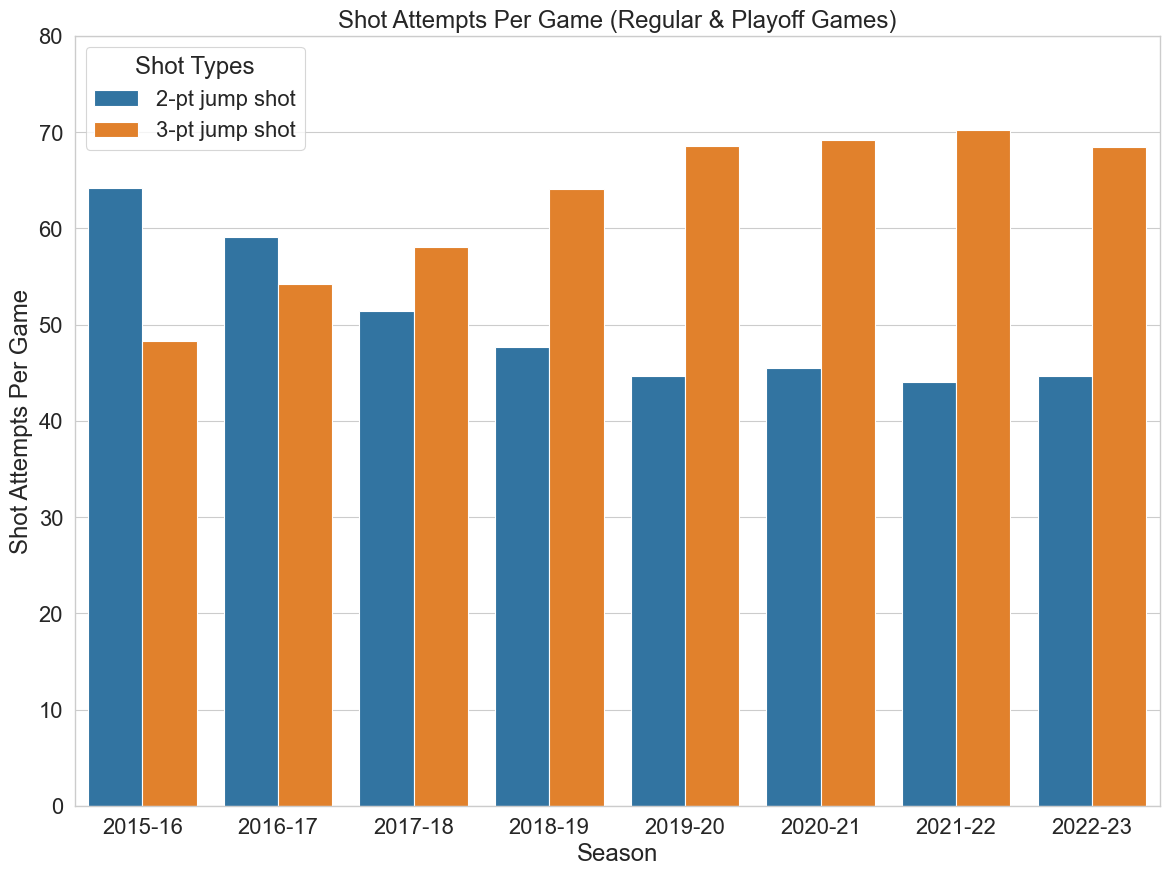

In [26]:
# plot 2 pt and 3 pt shot attempts per game over each season
# Create a figure with a subplot
fig, ax1 = plt.subplots(figsize=(14, 10))
sns.barplot(data=season_shots_df.query("ShotType in ['2-pt jump shot', '3-pt jump shot']"), x="SeasonYear", y="ShotAttemptsPerGame", hue='ShotType')
ax1.set_ylabel('Shot Attempts Per Game')
ax1.set_xlabel('Season')
ax1.set_title(f'Shot Attempts Per Game ({game_type_option})')
plt.ylim(0, 80)
plt.legend(title='Shot Types')
plt.show()

Has this translated to more points scored on average?

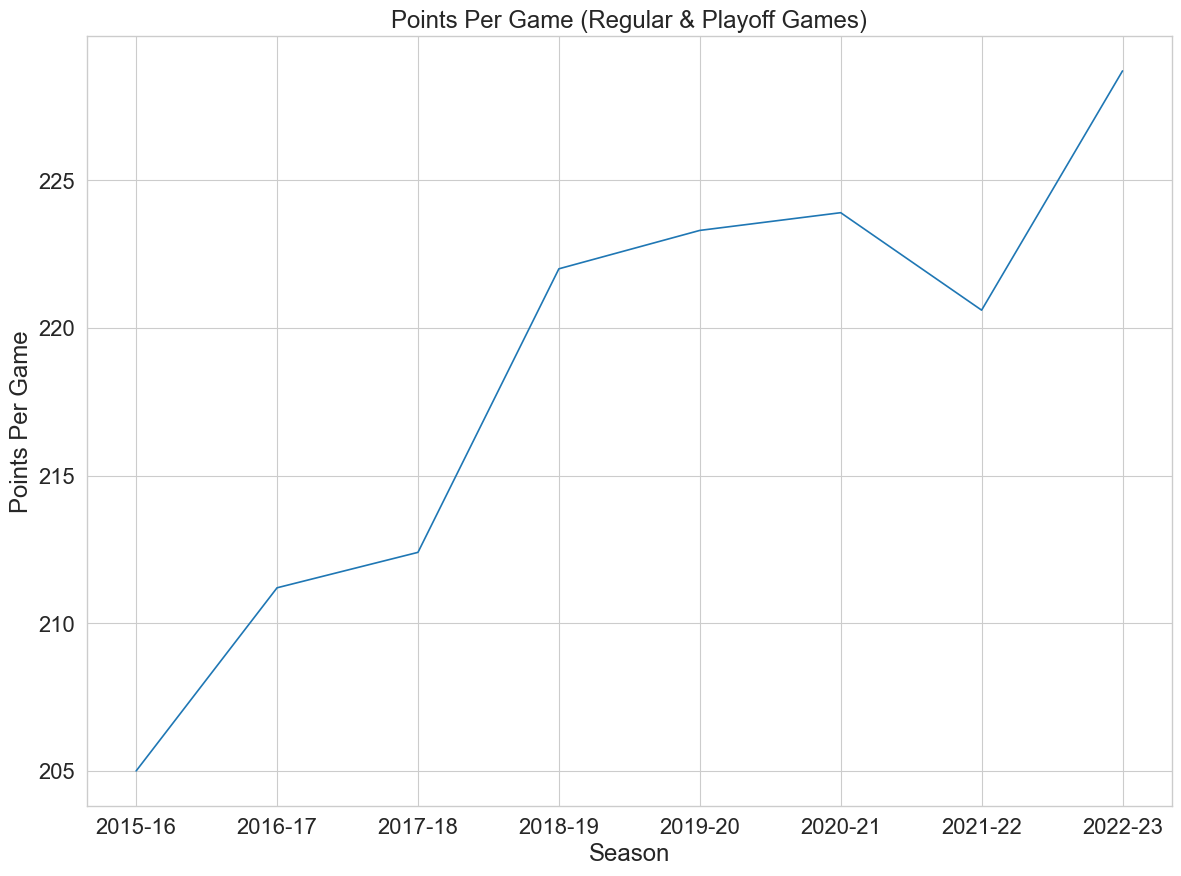

In [27]:
# plot points scored per game over each season
fig, ax1 = plt.subplots(figsize=(14, 10))
sns.lineplot(data=points_per_game_season, x="SeasonYear", y="PointsPerGame")
ax1.set_ylabel('Points Per Game')
ax1.set_xlabel('Season')
ax1.set_title(f'Points Per Game ({game_type_option})')
plt.show()

The following heatmap shows the average number of shots taken per game for different shot distances over the previous 8 NBA seasons. The plot uses a color gradient to represent the shot frequency, with darker colors indicating more shot attempts and lighter colors indicating less shot attempts. This visualization can help identify shooting trends and strategies employed by teams or players, such as an increased focus on three-point shooting or attempts from specific mid-range distances.

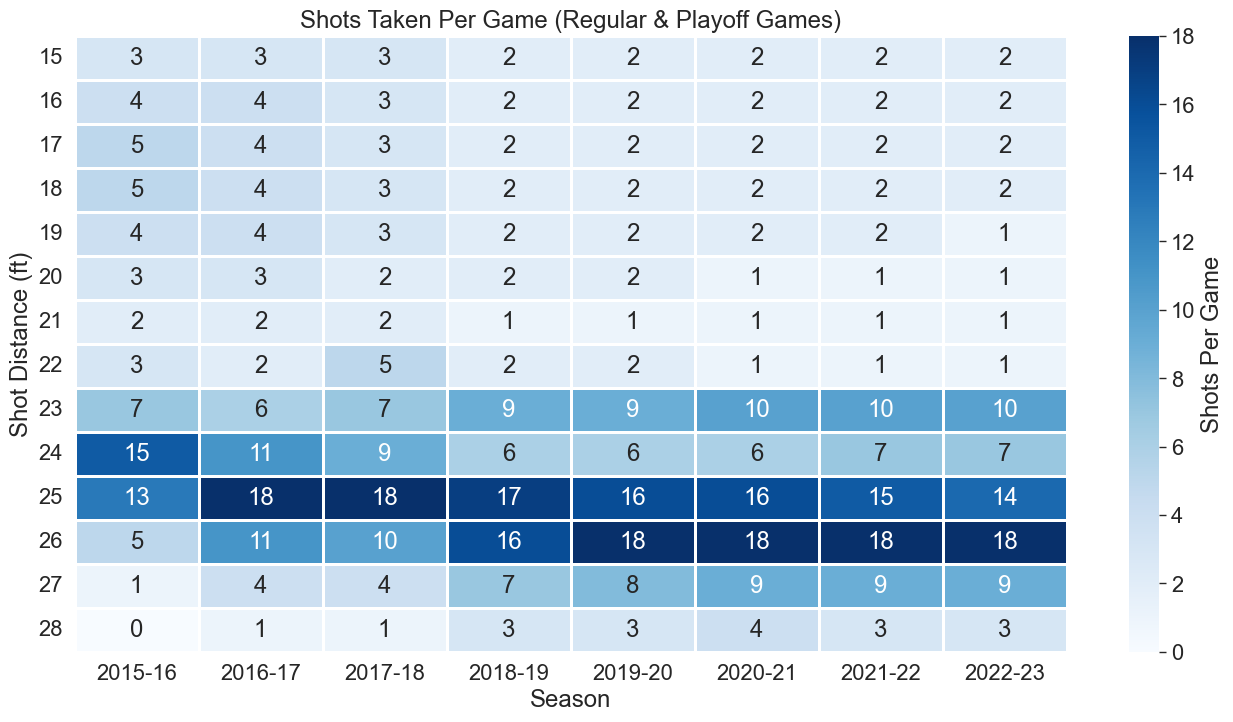

In [28]:
# create variable for the shot distance range to show
shot_ranges = np.arange(15, 29, 1)

# Filter the data to remove 'ShotDist (ft)' over 35
filtered_shots = shots.loc[shots['ShotDist (ft)'].isin(shot_ranges)]

# create heat map of year and count of shot distance
pivot_table = filtered_shots.pivot_table(index='ShotDist (ft)', columns='SeasonYear', aggfunc='size', fill_value=0)
num_games_series = num_games_season_df.set_index('SeasonYear')['NumGames']

# Divide the pivot table values by the number of games in the given season
pivot_table = pivot_table.div(num_games_series, axis='columns')

# convert all floats in pivot table to integers
pivot_table = pivot_table.astype(int)
pivot_table.index = pivot_table.index.astype(int)

# Create the heatmap using seaborn
plt.figure(figsize=(16, 8))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='d', linecolor='white', linewidth=1, cbar_kws={'label': 'Shots Per Game'})
plt.yticks(rotation=0)

# Set axis labels and title
plt.xlabel('Season')
plt.ylabel('Shot Distance (ft)')
plt.title(f'Shots Taken Per Game ({game_type_option})')

# Show the heatmap
plt.show()

Expected points scored per shot type: Expected points scored refers to the average number of points a basketball player is expected to score from a specific shot.

The following barplot illustrates the expected points scored for different shot ranges of two-point jump shots and three-point jump shots. This first-order analysis uses the league average for accuracy. This gives some insight on how the expected points scored vary based on shot distance and shot type. This can help identify the most effective shot ranges for maximizing points scored during basketball games.

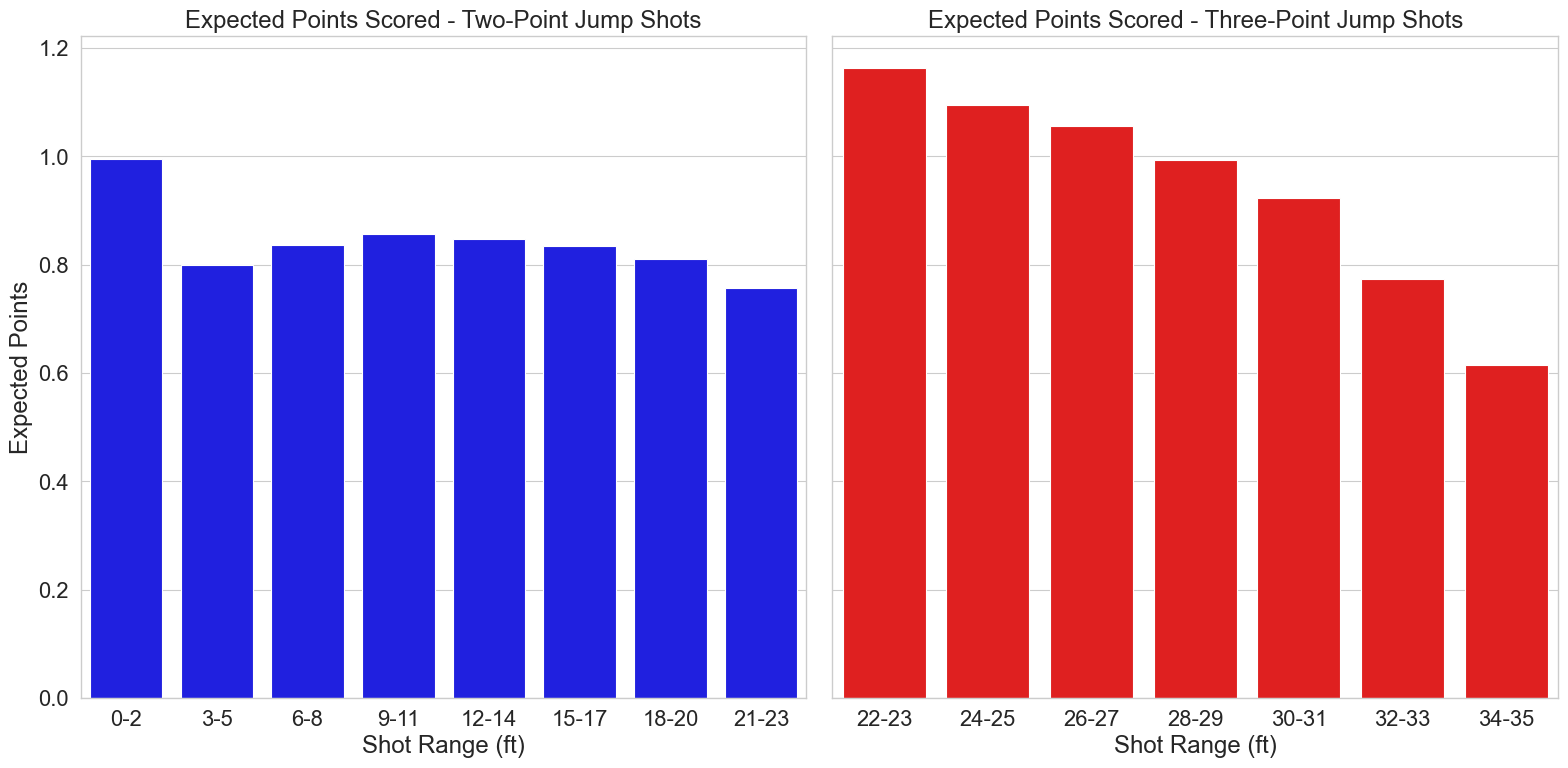

In [29]:
two_point_shot_interval = 3
three_point_shot_interval = 2
player = None

two_and_three_point_prob_df = get_expected_points_df(shots, two_point_shot_interval, three_point_shot_interval, 
                                                     top_x_players='all', previous_years='all')
# Create two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Filter the data for each ShotType
two_point_data = two_and_three_point_prob_df[two_and_three_point_prob_df['ShotType'] == '2-pt jump shot']
three_point_data = two_and_three_point_prob_df[two_and_three_point_prob_df['ShotType'] == '3-pt jump shot']

# Plot the first subplot (Two-Point shots)
sns.barplot(data=two_point_data, x='ShotInterval (ft)', y='ExpectedPoints', ax=ax1, color='blue')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.set_ylabel('Expected Points')
ax1.set_xlabel('Shot Range (ft)')
ax1.set_title('Expected Points Scored - Two-Point Jump Shots')

# Plot the second subplot (Three-Point shots)
sns.barplot(data=three_point_data, x='ShotInterval (ft)', y='ExpectedPoints', ax=ax2, color='red')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_ylabel('')
ax2.set_xlabel('Shot Range (ft)')
ax2.set_title('Expected Points Scored - Three-Point Jump Shots')

# Adjust the layout to avoid overlapping titles and labels
plt.tight_layout()

# Show the plots
plt.show()

It is interesting that even long range 3-pt shots of 28 ft. and longer have a higher expectation in points scored than mid and short-range 2-pt shots.

# correlation between 3-pt shot attempts and win percentage

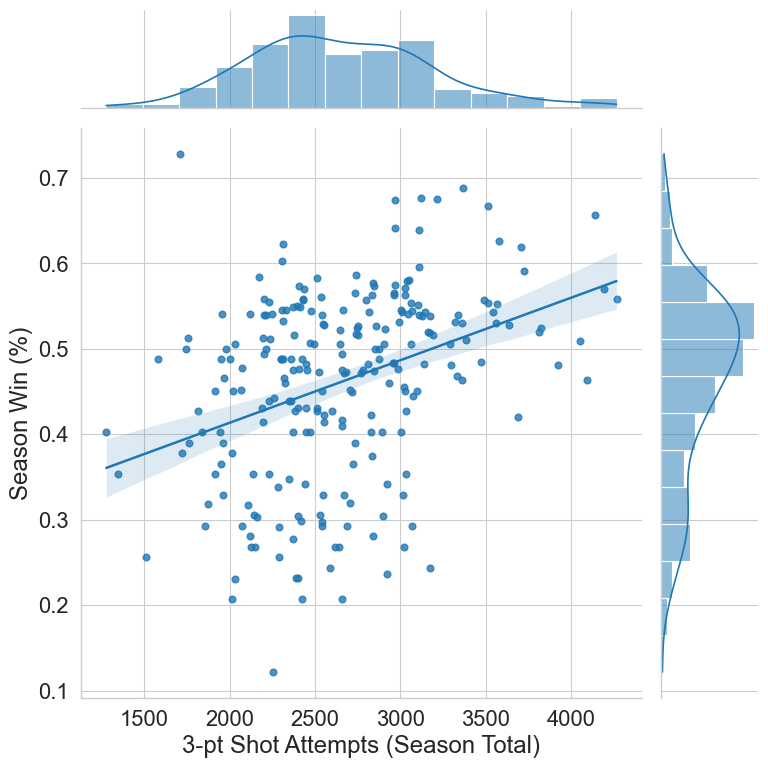

In [30]:
plot = sns.jointplot(data=team_shots_stats_and_record_by_season.query("ShotType in ['3-pt jump shot']"),
                  x='TotalShotAttempts', y='Season Win (%)', kind='reg', height=8)

plot.set_axis_labels('3-pt Shot Attempts (Season Total)', 'Season Win (%)')

plt.show()

## Remarks <a class="anchor" id="chapter5"></a>

NBA teams have significantly increased the amount of 3-pt attempts per game. Since the 2015-16 season, teams on average have taken 40% more 3-pt shots per game and less mid and long range 2-pt shots. This strategy has led to an increase in average points scored per game over the last eight seasons. The 2015-16 season was also Steph Curry’s historic unanimous MVP season in which he shot an average of 0.454 from 3-pt distance (the league average that season was 0.354). Curry’s great season likely helped shed more light on the importance of the 3-pt shot in the modern game.

Suggesting teams to increase their 3-pt attempts may seem like a straightforward strategy, since 3-pt shots have a clear edge in expected points scored, even from long range, well beyond the 3-pt line. However, this would assume the other team would not change their defensive scheme in response to the increase. Keeping the opposing defense honest with a variety of 2-pt shot attempts and plays down low around the rim may be what allows the offensive team to get off accurate 3-pt shots. Has the league found the right middle ground? It would also be interesting to see how the proximity of a defender affects the average probability of a player making a jump shot. Unfortunately, the play-by-play data I have does not have defender proximity distances on shots.

Players are also human, the probability of them making a 3-pt jump shot doesn’t necessarily stay constant during the course of a game. For example, a player could start off cold, and that can have an effect on their confidence. There is definitely a ‘feel’ aspect to shooting, even though a player is likely to score more points in expectation with a 3-pt shot, waning confidence and pressure can absolutely can have an acute influence on their accuracy. However, this data should give a shooter more confidence they are doing what’s statistically best for their team, especially those who are among the league’s best at 3-pt shooting. The data also suggests that players should practice much more on their 3-pt shooting if they are not already.